# Tennis Ball Tracking with Pinhole Camera Model

Pinhole camera model implementation for tennis ball trajectory tracking.

In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go

# Import simulation modules
import system_model
import scene

In [2]:
# Clean Pinhole Camera Implementation
class PinholeCamera:
    """
    Pinhole camera model with rotation for camera measurements.
    
    Coordinate System Convention:
    - World coordinates: Standard XYZ with Z=height/up
    - Camera coordinates: Camera-centered with camera looking along camera's -Z axis
    - Points in front of camera have negative Z in camera coordinates
    
    The coordinate transform follows these steps:
    1. Translate points from world coordinates to camera-centered coordinates
    2. Apply rotation to align with camera's coordinate system
    3. Project 3D points onto 2D image plane using perspective projection
    
    Key equations:
    - P_cam = R × (P_world − C)
    - u = f × (x_cam / −z_cam) + u₀
    - v = f × (y_cam / −z_cam) + v₀
    
    Where:
    - C: Camera center in world coordinates
    - R: Rotation matrix from world to camera
    - f: Focal length (in pixels)
    - (u₀, v₀): Principal point (image center)
    """
    
    def __init__(self, position, rotation_angles, focal_length=800, image_size=(1280, 960)):
        """
        Initialize a pinhole camera model.
        
        Args:
            position (list): [x, y, z] camera center in world coordinates
            rotation_angles (list): [roll, pitch, yaw] in radians
                - roll: rotation around X-axis
                - pitch: rotation around Y-axis (positive looks up, negative looks down)
                - yaw: rotation around Z-axis (0 points along +Y, π/2 points along +X)
            focal_length (float): Camera focal length in pixels
                - Controls zoom/FOV (higher values = more zoom, narrower FOV)
            image_size (tuple): (width, height) in pixels
        """
        self.C = np.array(position).reshape(3, 1)  # Camera center
        self.f = focal_length
        self.image_size = image_size
        self.u0, self.v0 = image_size[0]/2, image_size[1]/2  # Principal point
        
        # Build rotation matrix from Euler angles (ZYX convention)
        roll, pitch, yaw = rotation_angles
        
        # Individual rotation matrices
        Rx = np.array([  # Roll (around X)
            [1, 0, 0],
            [0, np.cos(roll), -np.sin(roll)],
            [0, np.sin(roll), np.cos(roll)]
        ])
        
        Ry = np.array([  # Pitch (around Y) 
            [np.cos(pitch), 0, np.sin(pitch)],
            [0, 1, 0],
            [-np.sin(pitch), 0, np.cos(pitch)]
        ])
        
        Rz = np.array([  # Yaw (around Z)
            [np.cos(yaw), -np.sin(yaw), 0],
            [np.sin(yaw), np.cos(yaw), 0],
            [0, 0, 1]
        ])
        
        # Combined rotation matrix (ZYX order: first yaw, then pitch, then roll)
        self.R = Rz @ Ry @ Rx
    
    def world_to_camera(self, world_coords):
        """
        Transform point from world coordinates to camera coordinates.
        
        Args:
            world_coords: [x, y, z] position in world coordinates
            
        Returns:
            camera_coords: [x_cam, y_cam, z_cam] position in camera coordinates
        """
        # Extract position coordinates if given state vector
        if len(world_coords) > 3:
            position = world_coords[:3]
        else:
            position = world_coords
            
        # Convert to column vector
        p_world = np.array(position).reshape(3, 1)
        
        # Transform: p_cam = R(p_world - C)
        p_cam = self.R @ (p_world - self.C)
        
        return p_cam
    
    def is_in_front(self, camera_coords):
        """Check if point is in front of camera (z_cam < 0)"""
        return camera_coords[2, 0] < 0
    
    def is_in_frame(self, pixel_coords):
        """Check if pixel coordinates are within image bounds"""
        u, v = pixel_coords
        return (0 <= u < self.image_size[0] and 0 <= v < self.image_size[1])
    
    def project(self, camera_coords):
        """
        Apply perspective projection to camera coordinates.
        
        Args:
            camera_coords: 3D point in camera coordinates
            
        Returns:
            pixel_coords: [u, v] pixel coordinates
        """
        # Extract coordinates
        x_cam = camera_coords[0, 0]
        y_cam = camera_coords[1, 0]
        z_cam = camera_coords[2, 0]
        
        # Perspective projection (note the negative z)
        # Since camera looks along -Z, we use -z_cam in denominator
        u = self.f * x_cam / (-z_cam) + self.u0
        v = self.f * y_cam / (-z_cam) + self.v0
        
        return np.array([u, v])
    
    def g(self, world_coords):
        """
        Measurement function: Maps 3D world coordinates to 2D pixel coordinates.
        
        Args:
            world_coords: [x, y, z] position in world coordinates,
                          or [x, y, z, vx, vy, vz] state vector
            
        Returns:
            pixel_coords: [u, v] pixel coordinates
            is_visible: bool, whether point is visible to camera
        """
        # Transform to camera coordinates
        p_cam = self.world_to_camera(world_coords)
        
        # Check if point is in front of camera
        if not self.is_in_front(p_cam):
            return np.array([0, 0]), False
        
        # Project to image plane
        pixel = self.project(p_cam)
        
        # Check if projection is within image bounds
        is_visible = self.is_in_frame(pixel)
        
        return pixel, is_visible
    
    def jacobian(self, world_coords):
        """
        Calculate Jacobian of measurement function for EKF.
        
        Args:
            world_coords: [x, y, z] position in world coordinates
            
        Returns:
            H: 2x3 Jacobian matrix of measurement function
            is_visible: bool, whether point is visible to camera
        """
        # Transform to camera coordinates
        p_cam = self.world_to_camera(world_coords)
        
        # Check if point is in front of camera
        if not self.is_in_front(p_cam):
            return None, False
        
        # Extract coordinates
        x_cam = p_cam[0, 0]
        y_cam = p_cam[1, 0]
        z_cam = p_cam[2, 0]
        
        # Compute Jacobian for perspective projection
        # ∂u/∂x_cam = f/(-z_cam)
        # ∂u/∂y_cam = 0
        # ∂u/∂z_cam = f*x_cam/z_cam²
        # ∂v/∂x_cam = 0
        # ∂v/∂y_cam = f/(-z_cam)
        # ∂v/∂z_cam = f*y_cam/z_cam²
        J_proj = np.array([
            [self.f/(-z_cam), 0, self.f*x_cam/(z_cam*z_cam)],
            [0, self.f/(-z_cam), self.f*y_cam/(z_cam*z_cam)]
        ])
        
        # Jacobian of camera transform is just the rotation matrix
        J_cam = self.R
        
        # Full Jacobian is composition: H = J_proj @ J_cam
        H = J_proj @ J_cam
        
        # Check if projection is within image bounds
        pixel = self.project(p_cam)
        is_visible = self.is_in_frame(pixel)
        
        return H, is_visible

In [3]:
# Tennis ball simulation setup - extended for full bounce trajectory
x0 = np.array([0, 0, 1.0, 20.0, 0.0, 5.0])  # Initial state [x,y,z,vx,vy,vz]
model = system_model.SystemModel(x0, 5, 0.1)
# Default bounces=2 covers full trajectory
t, x_full = model.run_sim()

# Convert to numpy arrays and extract positions only
import numpy as np

t = np.asarray(t)
x_full = np.asarray(x_full)
x = x_full[:, :3]  # [x, y, z] positions only

print(f"Trajectory: {len(t)} points over {t[-1]:.1f} seconds")
print(f"Range: X=[{x[:,0].min():.1f}, {x[:,0].max():.1f}]m, Z=[{x[:,2].min():.1f}, {x[:,2].max():.1f}]m")

if len(model.x_impact) > 0:
    for idx, bounce in enumerate(model.x_impact, start=1):
        pos = bounce[:3]
        print(f"Bounce {idx} at: ({pos[0]:.1f}, {pos[1]:.1f}, {pos[2]:.1f})")
    print(f"Total trajectory segments: {len(model.x_impact) + 1}")
else:
    print("No bounces detected")

Trajectory: 28 points over 2.0 seconds
Range: X=[0.0, 29.8]m, Z=[-0.0, 2.1]m
Bounce 1 at: (19.0, 0.0, -0.0)
Bounce 2 at: (29.8, 0.0, -0.0)
Total trajectory segments: 3


In [54]:
# Set up cameras for trajectory coverage
print("Setting up cameras for trajectory coverage...")

# Compute trajectory bounds for placement
x_min, x_max = x[:, 0].min(), x[:, 0].max()
y_min, y_max = x[:, 1].min(), x[:, 1].max()
z_max = x[:, 2].max()

# Calculate center of trajectory
traj_center_x = (x_min + x_max) / 2
traj_center_y = (y_min + y_max) / 2

# TUNE THESE:
# - Place cameras closer to the court (better visibility, less extreme perspective)
# - Use moderate focal length (balance between FOV and detail)
# - Adjust pitch angle to center the view on the trajectory
camera_params = {
    'distance': 50,  # Meters from court centerline
    'elevation': 4,                # Meters above ground
    'focal_length': 1000         # Pixels (higher = more zoom, narrower FOV)
}

# Camera 1: left side
camera1 = PinholeCamera(
    position=[traj_center_x, traj_center_y - camera_params['distance'], camera_params['elevation']],
    rotation_angles=[-np.pi/2, 0, 0],  # Roll (x), pitch (y), yaw (z)
    focal_length=camera_params['focal_length'],
    image_size=(1280, 960)
)

# Camera 2: right side
camera2 = PinholeCamera(
    position=[traj_center_x, traj_center_y + camera_params['distance'], camera_params['elevation']],
    rotation_angles=[np.pi/2, 0, 0],  # roll (x), pitch (y), yaw (z)
    focal_length=camera_params['focal_length'],
    image_size=(1280, 960)
)

cameras = [camera1, camera2]
print(f"\nPositioned {len(cameras)} cameras:")
print(f"Camera 1: ({camera1.C[0,0]:.1f}, {camera1.C[1,0]:.1f}, {camera1.C[2,0]:.1f}) m")
print(f"Camera 2: ({camera2.C[0,0]:.1f}, {camera2.C[1,0]:.1f}, {camera2.C[2,0]:.1f}) m")

# Calculate expected field of view in real-world units
def calculate_fov(camera):
    """Calculate approximate Field of View at a reference distance"""
    distance = 10  # Reference distance in meters
    width = 2 * distance * camera.image_size[0] / (2 * camera.f)
    height = 2 * distance * camera.image_size[1] / (2 * camera.f)
    
    # Calculate approximate FOV angles
    horiz_fov = 2 * np.arctan(width / (2 * distance))
    vert_fov = 2 * np.arctan(height / (2 * distance))
    
    return {
        'width': width, 
        'height': height,
        'horiz_fov': np.degrees(horiz_fov),
        'vert_fov': np.degrees(vert_fov)
    }

# Show FOV info for first camera (they're identical)
fov = calculate_fov(cameras[0])
print(f"\nCamera field of view at 10m distance:")
print(f"  Width × Height: {fov['width']:.1f}m × {fov['height']:.1f}m")
print(f"  Horizontal FOV: {fov['horiz_fov']:.1f}°")
print(f"  Vertical FOV: {fov['vert_fov']:.1f}°")

Setting up cameras for trajectory coverage...

Positioned 2 cameras:
Camera 1: (14.9, -50.0, 4.0) m
Camera 2: (14.9, 50.0, 4.0) m

Camera field of view at 10m distance:
  Width × Height: 12.8m × 9.6m
  Horizontal FOV: 65.2°
  Vertical FOV: 51.3°


In [55]:
# Generate measurements for trajectory
measurements = []
coverage_stats = []

print("\nAnalyzing trajectory coverage...")

for i, cam in enumerate(cameras):
    cam_measurements = []
    visible_count = 0
    
    # Process each point in trajectory
    for j, point in enumerate(x):
        # Get the 3D position only for camera measurement
        world_coords = point[:3] if len(point) > 3 else point
        pixel, visible = cam.g(world_coords)
        cam_measurements.append(pixel)
        if visible:
            visible_count += 1
    
    # Store measurements and calculate stats
    measurements.append(np.array(cam_measurements))
    coverage = 100 * visible_count / len(x)
    coverage_stats.append(coverage)
    
    # Print coverage report
    print(f"Camera {i+1}: {visible_count}/{len(x)} points visible ({coverage:.1f}%)")

# Check stereo coverage
stereo_visible = 0
for j in range(len(x)):
    world_coords = x[j,:3] if x.shape[1] > 3 else x[j]
    cam1_visible = cameras[0].g(world_coords)[1]
    cam2_visible = cameras[1].g(world_coords)[1]
    if cam1_visible and cam2_visible:
        stereo_visible += 1

stereo_coverage = 100 * stereo_visible / len(x)
print(f"\nStereo coverage: {stereo_visible}/{len(x)} points visible to both cameras ({stereo_coverage:.1f}%)")

# Debug camera coverage issues if below threshold
if min(coverage_stats) < 95:
    print("\nCoverage below 95%. Debugging camera setup...")
    # Check trajectory extremes (start, middle, end)
    check_indices = [0, len(x)//2, -1]
    for idx in check_indices:
        point = x[idx]
        world_coords = point[:3] if len(point) > 3 else point
        print(f"\nPoint {idx}: Position ({world_coords[0]:.1f}, {world_coords[1]:.1f}, {world_coords[2]:.1f})")
        for cam_idx, cam in enumerate(cameras):
            pixel, visible = cam.g(world_coords)
            if visible:
                print(f"  Camera {cam_idx+1}: VISIBLE at pixel ({pixel[0]:.0f}, {pixel[1]:.0f})")
            else:
                p_cam = cam.R @ (np.array(world_coords).reshape(3, 1) - cam.C)
                reason = "behind camera" if p_cam[2, 0] >= 0 else "outside frame"
                print(f"  Camera {cam_idx+1}: NOT VISIBLE ({reason})")


Analyzing trajectory coverage...
Camera 1: 28/28 points visible (100.0%)
Camera 2: 28/28 points visible (100.0%)

Stereo coverage: 28/28 points visible to both cameras (100.0%)


In [56]:
import numpy as np
import plotly.graph_objects as go

# 3D visualization of cameras and trajectory with proper view frustum
fig = go.Figure()

# Draw tennis court and ball trajectory
scene.draw_court(fig)
scene.plot_ball_trajectory(fig, x)  # assumes this names its trace “Ball” or similar

# Add bounce points
for i, bounce in enumerate(model.x_impact):
    fig.add_trace(go.Scatter3d(
        x=[bounce[0]],
        y=[bounce[1]],
        z=[bounce[2]],
        mode='markers',
        marker=dict(size=10, color='orange', symbol='x'),
        name=f'Bounce {i+1}',
        showlegend=True
    ))

def draw_camera_frustum(fig, cam, color, cam_name, near_plane=5, far_plane=25):
    pos = cam.C.flatten()
    R_inv = cam.R.T

    # camera center (no legend)
    fig.add_trace(go.Scatter3d(
        x=[pos[0]], y=[pos[1]], z=[pos[2]],
        mode='markers',
        marker=dict(size=12, color=color, symbol='diamond'),
        showlegend=False
    ))

    # frustum planes at near and far (no legend)
    planes = []
    for depth in (near_plane, far_plane):
        w = depth * cam.image_size[0] / cam.f
        h = depth * cam.image_size[1] / cam.f
        corners_cam = np.array([
            [-w/2, -h/2, -depth],
            [ w/2, -h/2, -depth],
            [ w/2,  h/2, -depth],
            [-w/2,  h/2, -depth],
        ])
        plane_world = [(R_inv @ c.reshape(3,1) + cam.C).flatten() for c in corners_cam]
        planes.append(np.array(plane_world))

    # edges
    for i in range(4):
        # near→far
        fig.add_trace(go.Scatter3d(
            x=[planes[0][i,0], planes[1][i,0]],
            y=[planes[0][i,1], planes[1][i,1]],
            z=[planes[0][i,2], planes[1][i,2]],
            mode='lines',
            line=dict(color=color, width=2, dash='dot'),
            showlegend=False
        ))
        # center→near
        fig.add_trace(go.Scatter3d(
            x=[pos[0], planes[0][i,0]],
            y=[pos[1], planes[0][i,1]],
            z=[pos[2], planes[0][i,2]],
            mode='lines',
            line=dict(color=color, width=2),
            showlegend=False
        ))

    # outlines of near & far
    for plane in planes:
        loop = np.vstack([plane, plane[0]])
        fig.add_trace(go.Scatter3d(
            x=loop[:,0],
            y=loop[:,1],
            z=loop[:,2],
            mode='lines',
            line=dict(color=color, width=2),
            showlegend=False
        ))

    # optical axis → “view direction”
    mid = (near_plane + far_plane) / 2
    end = (R_inv @ np.array([0, 0, -mid]).reshape(3,1) + cam.C).flatten()
    fig.add_trace(go.Scatter3d(
        x=[pos[0], end[0]],
        y=[pos[1], end[1]],
        z=[pos[2], end[2]],
        mode='lines',
        line=dict(color=color, width=4),
        name=f"{cam_name} view direction",
        showlegend=True
    ))

# draw cameras
colors = ['red', 'blue']
for i, cam in enumerate(cameras):
    draw_camera_frustum(
        fig, cam, colors[i], f"Camera {i+1}",
        near_plane=5, far_plane=20
    )

scene.show_scene(fig)
fig.update_layout(title='Tennis Ball Tracking: Camera Setup with View Frustum')
fig.show()



Generating camera views...


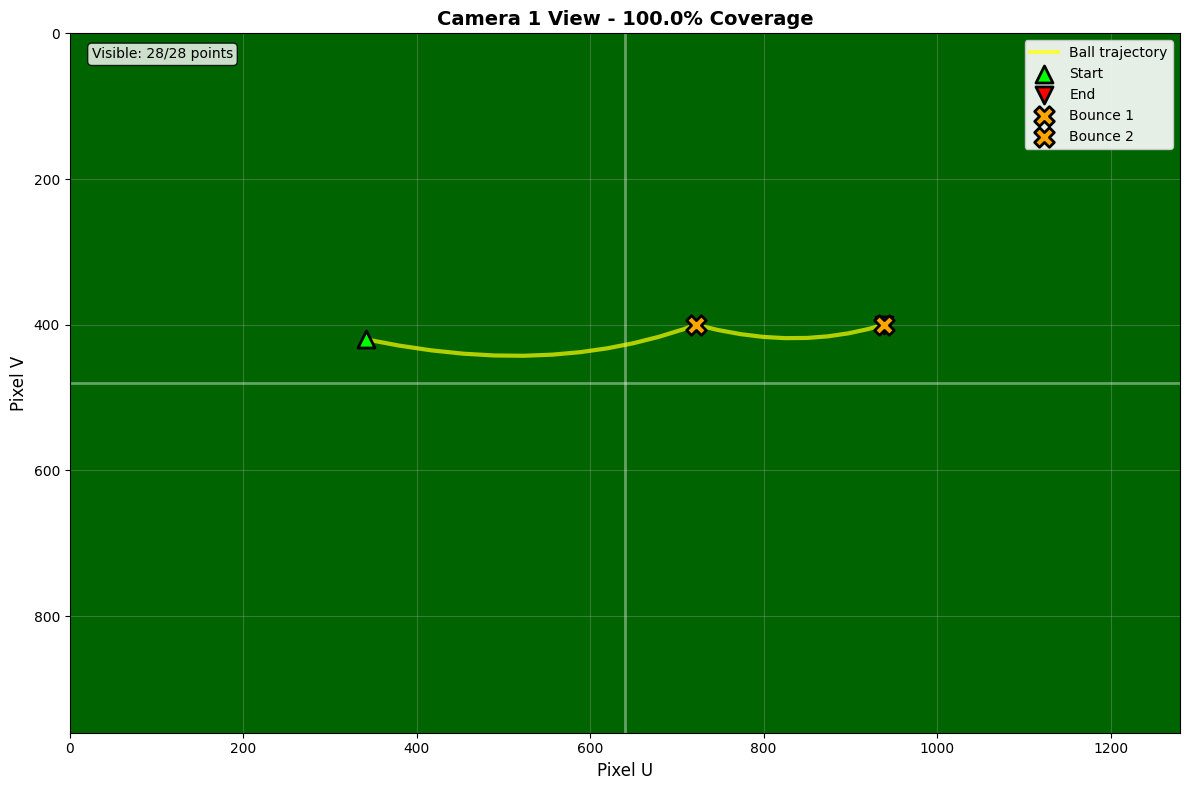

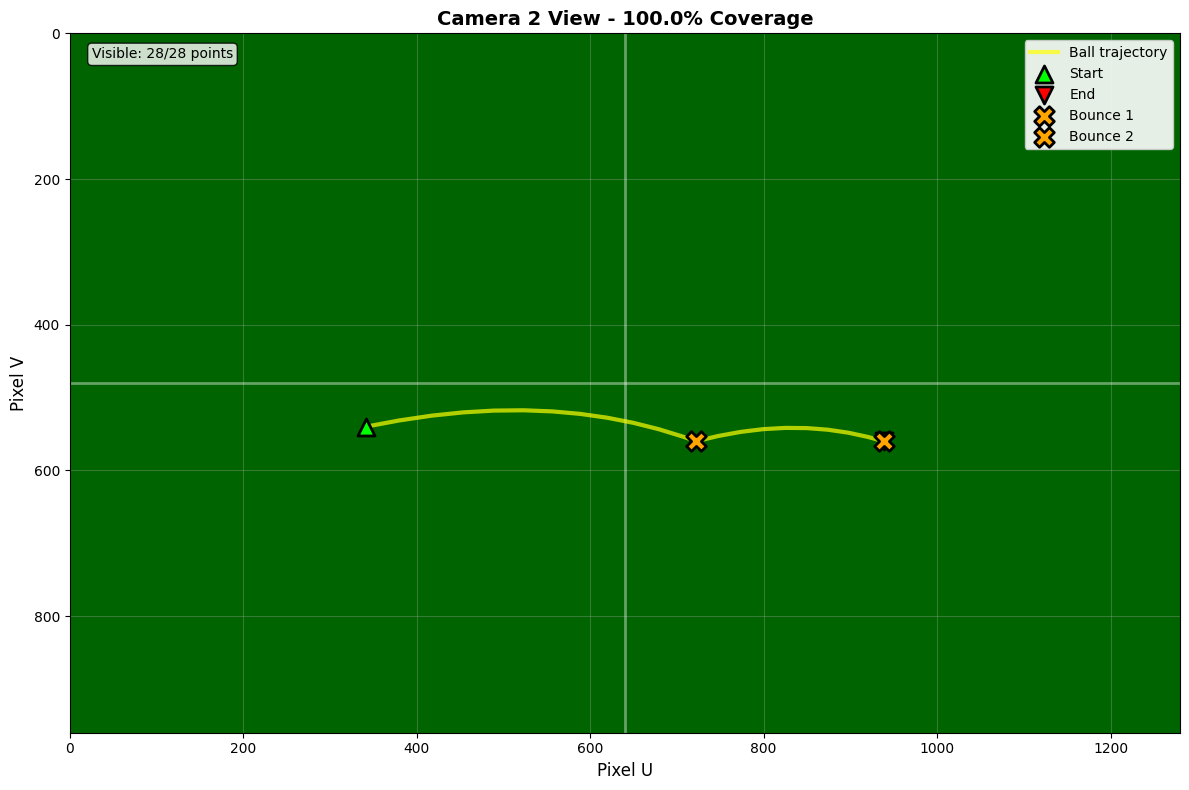

Camera views generated!


In [58]:
# Generate camera views
print("\nGenerating camera views...")

for i, (cam, meas) in enumerate(zip(cameras, measurements)):
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Set up image coordinates
    ax.set_xlim(0, cam.image_size[0])
    ax.set_ylim(cam.image_size[1], 0)  # Inverted y-axis for image coordinates
    ax.set_facecolor('darkgreen')
    
    # Add court reference lines
    ax.axhline(y=cam.image_size[1]//2, color='white', linewidth=2, alpha=0.4)
    ax.axvline(x=cam.image_size[0]//2, color='white', linewidth=2, alpha=0.4)
    
    # Plot trajectory points that are visible
    visible_pixels = []
    visible_indices = []
    
    for j, point in enumerate(x):
        world_coords = point[:3] if len(point) > 3 else point
        pixel, visible = cam.g(world_coords)
        if visible:
            visible_pixels.append(pixel)
            visible_indices.append(j)
    
    if visible_pixels:
        visible_pixels = np.array(visible_pixels)
        
        # Plot trajectory path
        ax.plot(visible_pixels[:, 0], visible_pixels[:, 1], 
               'yellow', linewidth=3, alpha=0.7, label='Ball trajectory')
        
        # Mark key points: start and end of visible trajectory
        ax.scatter(visible_pixels[0, 0], visible_pixels[0, 1], 
                  c='lime', s=150, marker='^', edgecolors='black', linewidth=2, 
                  label='Start', zorder=10)
        
        if len(visible_pixels) > 1:
            ax.scatter(visible_pixels[-1, 0], visible_pixels[-1, 1], 
                      c='red', s=150, marker='v', edgecolors='black', linewidth=2,
                      label='End', zorder=10)
    
    # Mark bounce points if visible
    for bounce_idx, bounce_point in enumerate(model.x_impact):
        bounce_pixel, bounce_visible = cam.g(bounce_point[:3])
        if bounce_visible:
            ax.scatter(bounce_pixel[0], bounce_pixel[1], 
                      c='orange', s=200, marker='X', edgecolors='black', linewidth=2,
                      label=f'Bounce {bounce_idx+1}', zorder=10)
    
    # Add title and labels
    ax.set_title(f'Camera {i+1} View - {coverage_stats[i]:.1f}% Coverage', fontsize=14, fontweight='bold')
    ax.set_xlabel('Pixel U', fontsize=12)
    ax.set_ylabel('Pixel V', fontsize=12)
    ax.grid(True, alpha=0.3)
    
    # Add legend and coverage info
    ax.legend(loc='upper right', framealpha=0.9)
    coverage_text = f'Visible: {int(coverage_stats[i]*len(x)/100)}/{len(x)} points'
    ax.text(0.02, 0.98, coverage_text, transform=ax.transAxes, 
           bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
           verticalalignment='top', fontsize=10)
    
    plt.tight_layout()
    plt.show()

print("Camera views generated!")

In [59]:
# Function to extract measurements for EKF
def get_ekf_measurements(cameras, trajectory, noise_std=1.0):
    """
    Generate camera measurements with noise for use in Extended Kalman Filter.
    
    Args:
        cameras: List of PinholeCamera objects
        trajectory: Nx3 array of trajectory positions
        noise_std: Standard deviation of measurement noise in pixels
        
    Returns:
        measurements: List of measurement arrays per camera
        visibilities: List of boolean arrays indicating visible points
    """
    all_measurements = []
    all_visibilities = []
    
    for cam in cameras:
        camera_measurements = []
        camera_visibilities = []
        
        for point in trajectory:
            # Extract position coordinates if needed
            world_coords = point[:3] if len(point) > 3 else point
            pixel, visible = cam.g(world_coords)
            
            if visible:
                # Add Gaussian noise to measurements
                noisy_pixel = pixel + np.random.normal(0, noise_std, size=2)
                camera_measurements.append(noisy_pixel)
            else:
                # For invisible points, add NaN values
                camera_measurements.append(np.array([np.nan, np.nan]))
            
            camera_visibilities.append(visible)
        
        all_measurements.append(np.array(camera_measurements))
        all_visibilities.append(np.array(camera_visibilities))
    
    return all_measurements, all_visibilities

# Example usage
noise_std = 1.5  # 1.5 pixel standard deviation noise
ekf_measurements, ekf_visibilities = get_ekf_measurements(cameras, x, noise_std)

# Print statistics about EKF measurements
print("EKF Measurement Statistics:")
for i, (meas, vis) in enumerate(zip(ekf_measurements, ekf_visibilities)):
    visible_count = np.sum(vis)
    print(f"Camera {i+1}: {visible_count}/{len(vis)} measurements available ({100*visible_count/len(vis):.1f}%)")

EKF Measurement Statistics:
Camera 1: 28/28 measurements available (100.0%)
Camera 2: 28/28 measurements available (100.0%)
